# Spotted the fraudsters

Let's look in detail at a full solution for the previous activities you completed on the credit card dataset.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv('data/credit_cards.csv', encoding='latin1')
print(dataset.head(10))

                    CC            No    Money               City  \
0  5110 0000 0000 0000  1.610000e+12  $6,871              Amlwch   
1  5294 4409 1242 9950  1.680000e+12  $7,965       North Saanich   
2  5380 0000 0000 0000  1.650000e+12  $7,927              Amlwch   
3  5530 0000 0000 0000  1.630000e+12  $9,525                Ajax   
4  5570 0000 0000 0000  1.630000e+12  $7,008   Pont-Saint-Martin   
5  5150 0000 0000 0000  1.650000e+12  $5,138              Amlwch   
6    514515 2300050725  1.650000e+12  $6,921                Ajax   
7  5288 2331 4441 1377  1.640000e+12  $7,821   Pont-Saint-Martin   
8   538649 550458 1435  1.680000e+12  $7,426              Canoas   
9   522306 558047 9692  1.650000e+12  $7,344              Canoas   

             Phone  Fraud  
0    070 2858 8300      1  
1     07588 093717      1  
2    0800 236 8313      1  
3  (0116) 834 5299      0  
4    (016977) 0477      1  
5      0500 593141      0  
6        0800 1111      0  
7    0933 242 2375      1  

## Converting alphanumeric into numeric variables

The money variable is numeric, but not in the right format. We can see that, first of all, it contains a dollar sign, which prevents it from being read as a number. Secondly, the comma is incorporated in the text as well. We need to address both of these issues.

In [2]:
# Removing the dollar sign by treating the value as a string and only selecting
# the characters after the first one (which is the dollar sign)
money = []
for amount in dataset['Money']:
    money.append(amount[1:])

# Next, remove the comma and transform the text into an integer
for index, amount in enumerate(money):
    money[index] = int(amount.replace(',',''))
dataset['Money'] = money
dataset['Money'].head()

0    6871
1    7965
2    7927
3    9525
4    7008
Name: Money, dtype: int64

## Removing variables that have no predictive value

Let's look at the number of unique values per variable:

In [3]:
for var in dataset.columns:
    print(var, ' ', len(dataset[var].unique()))

CC   97
No   9
Money   98
City   5
Phone   95
Fraud   2


The unique values per variable indicate that the categorical variables CC and Phone are containing almost only unique values (we have 99 observations). For the continuous variables, No and Money, this is not a problem of course. Hence, we are going to remove CC and Phone.

In [4]:
dataset_cleanest = dataset.drop(['CC','Phone'], axis=1)
dataset_cleanest.head(10)

,No,Money,City,Fraud
0,1.610000e+12,6871,Amlwch,1
1,1.680000e+12,7965,North Saanich,1
2,1.650000e+12,7927,Amlwch,1
3,1.630000e+12,9525,Ajax,0
4,1.630000e+12,7008,Pont-Saint-Martin,1
5,1.650000e+12,5138,Amlwch,0
6,1.650000e+12,6921,Ajax,0
7,1.640000e+12,7821,Pont-Saint-Martin,1
8,1.680000e+12,7426,Canoas,1
9,1.650000e+12,7344,Canoas,1


## Removing outliers

Add a column called 'outlier' to the dataset containing a -1/1 flag for outliers:

In [5]:
from sklearn.neighbors import LocalOutlierFactor

# Copy dataset and only retain continuous variables
dataset_no_out = dataset_cleanest.copy()[['No', 'Money']]
    
loc = LocalOutlierFactor(n_neighbors = 20, contamination = 0.2)
outliers_loc = loc.fit_predict(dataset_no_out)
dataset_no_out['outlier'] = pd.DataFrame(outliers_loc)

Let's visualise this:

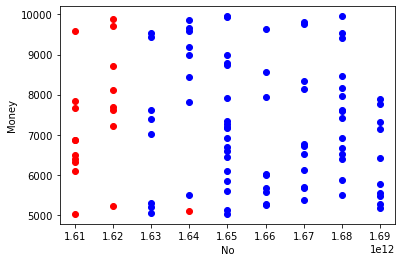

In [6]:
for index, obs in dataset_no_out.iterrows():
    if obs['outlier'] > 0:
        plt.scatter(obs[0], obs[1], color='blue')
    else:
        plt.scatter(obs[0], obs[1], color='red')
plt.xlabel('No')
plt.ylabel('Money')
plt.show()

With other parameters:

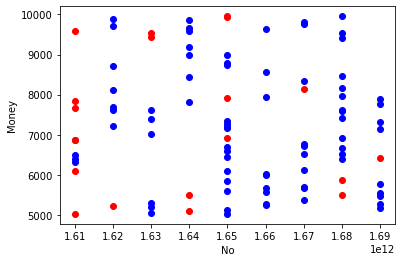

In [7]:
loc = LocalOutlierFactor(n_neighbors = 2, contamination = 0.2)
outliers_loc = loc.fit_predict(dataset_no_out)
dataset_no_out['outlier'] = pd.DataFrame(outliers_loc)

for index, obs in dataset_no_out.iterrows():
    if obs['outlier'] > 0:
        plt.scatter(obs[0], obs[1], color='blue')
    else:
        plt.scatter(obs[0], obs[1], color='red')
plt.xlabel('No')
plt.ylabel('Money')
plt.show()

By using a Gaussian distribution:

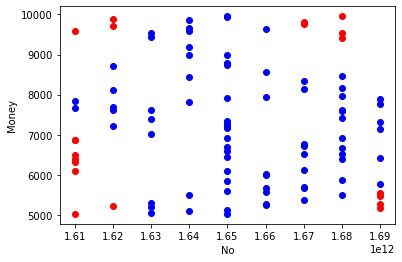

In [13]:
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope(contamination = 0.2)
outliers_loc = ee.fit_predict(dataset_no_out)
dataset_no_out['outlier'] = pd.DataFrame(outliers_loc)

for index, obs in dataset_no_out.iterrows():
    if obs['outlier'] > 0:
        plt.scatter(obs[0], obs[1], color='blue')
    else:
        plt.scatter(obs[0], obs[1], color='red')
plt.xlabel('No')
plt.ylabel('Money')
plt.show()

## Transforming numeric variables

Applying standardisation is simple:

In [9]:
from sklearn.preprocessing import StandardScaler

dataset_trans = dataset_no_out.copy()
ss = StandardScaler()

# Note that we only retain the continuous variables
dataset_trans = ss.fit_transform(dataset_trans[['No','Money']])
dataset_trans = pd.DataFrame(data = dataset_trans, columns = ['No', 'Money'])
dataset_trans.head()

,No,Money
0,-1.716197,-0.254860
1,1.095445,0.468902
2,-0.109545,0.443762
3,-0.912871,1.500958
4,-0.912871,-0.164224


Visualisation:

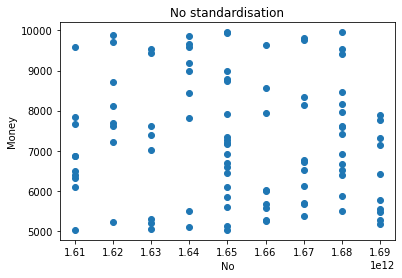

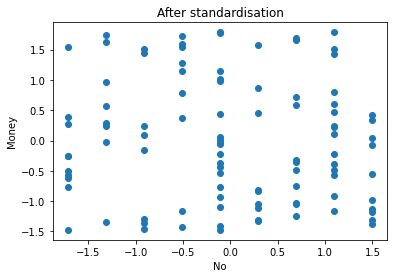

In [10]:
plt.scatter(dataset_no_out['No'], dataset_no_out['Money'])
plt.title('No standardisation')
plt.xlabel('No')
plt.ylabel('Money')
plt.show()

plt.scatter(dataset_trans['No'], dataset_trans['Money'])
plt.title('After standardisation')
plt.xlabel('No')
plt.ylabel('Money')
plt.show()

Using min-max scaling:

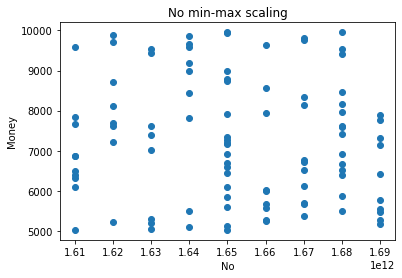

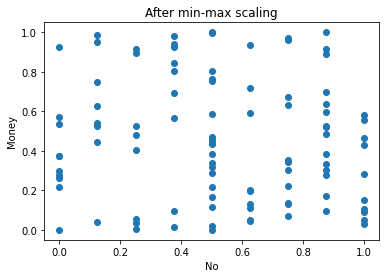

In [11]:
from sklearn.preprocessing import MinMaxScaler

dataset_trans = dataset_no_out.copy()
mms = MinMaxScaler()

# Note that we onyl retain the continuous variables
dataset_trans = mms.fit_transform(dataset_trans[['No','Money']])
dataset_trans = pd.DataFrame(data = dataset_trans, columns = ['No', 'Money'])

plt.scatter(dataset_no_out['No'], dataset_no_out['Money'])
plt.title('No min-max scaling')
plt.xlabel('No')
plt.ylabel('Money')
plt.show()

plt.scatter(dataset_trans['No'], dataset_trans['Money'])
plt.title('After min-max scaling')
plt.xlabel('No')
plt.ylabel('Money')
plt.show()